In [29]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

dataroot = '../WaterLevelPrediction_SelectingModel//Data/'

In [30]:
df = pd.read_pickle(dataroot+'finaldata.pkl')

Cross Validation

In [31]:
from sklearn.model_selection import TimeSeriesSplit

tss = TimeSeriesSplit(n_splits=6, test_size=365)
df = df.sort_index()

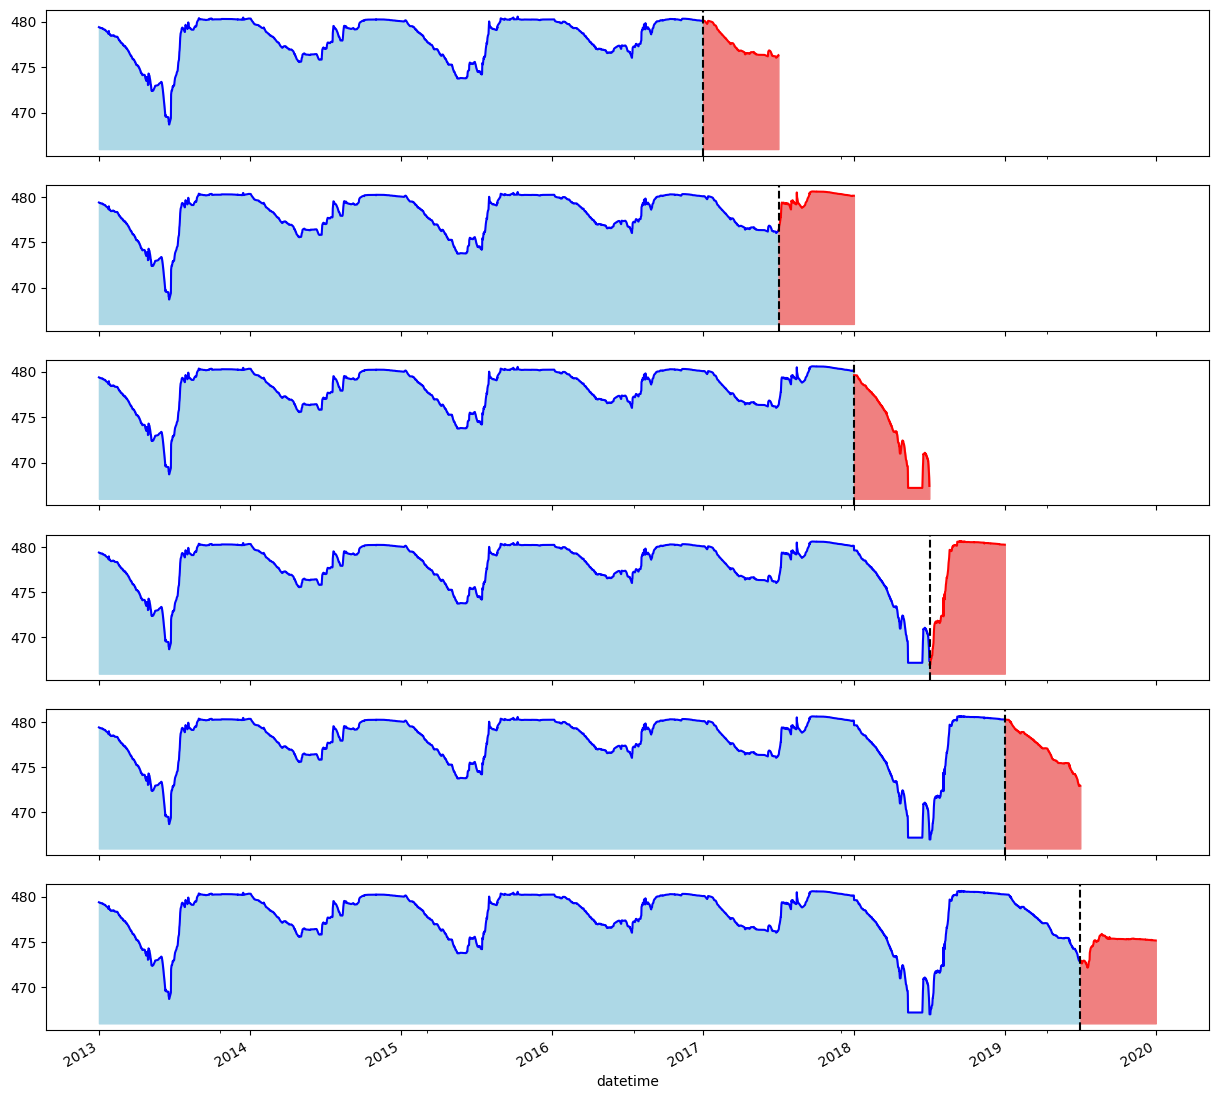

In [32]:
fig, axs = plt.subplots(6,1, figsize = (15,15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    train['water_level'].plot(ax=axs[fold],
                              label='Tập huấn luyện',
                              color='blue')
    test['water_level'].plot(ax=axs[fold],
                             label='Tập kiểm thử',
                             color='red')
    axs[fold].fill_between(train.index,466, train['water_level'], color='lightblue')
    axs[fold].fill_between(test.index,466, test['water_level'], color='lightcoral')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold+=1
plt.show()

Train the model with first features set

In [35]:
from sklearn.ensemble import RandomForestRegressor

fold = 0
train_preds = []
test_preds = []
train_rmses = []
test_rmses = []
train_maes = []
test_maes = []
train_r2s = []
test_r2s = []
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    
    features = ['precipitation','sluice_status']
    target = 'water_level'
    
    X_train = train[features]
    y_train = train[target]
    
    X_test = test[features]
    y_test = test[target]
    
    rf_reg = RandomForestRegressor(verbose=1,
                                    n_jobs=-1,
                                    oob_score=True)
    rf_reg.fit(X_train, y_train)
    
    y_train_pred = rf_reg.predict(X_train)
    train_preds.append(y_train_pred)
    y_test_pred = rf_reg.predict(X_test)
    test_preds.append(y_test_pred)
    train_rmse = np.sqrt(mean_squared_error(y_train,y_train_pred))
    train_rmses.append(train_rmse)
    test_rmse = np.sqrt(mean_squared_error(y_test,y_test_pred))
    test_rmses.append(test_rmse)
    train_mae = mean_absolute_error(y_train,y_train_pred)
    train_maes.append(train_mae)
    test_mae = mean_absolute_error(y_test,y_test_pred)
    test_maes.append(test_mae)
    train_r2 = r2_score(y_train,y_train_pred)
    train_r2s.append(train_r2)
    test_r2 = r2_score(y_test,y_test_pred)
    test_r2s.append(test_r2)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0

In [36]:
oob_error = 1 - rf_reg.oob_score_
print(f'Out-of-Bag Error (OOB): {oob_error}')

Out-of-Bag Error (OOB): 0.9460877568286633


Model Evaluation

In [7]:
print(f'root mean squared error on train set:{np.mean(train_rmses)}')
print(f'score for each fold:{train_rmses}')
print(f'root mean squared error on test set:{np.mean(test_rmses)}')
print(f'score for each fold:{test_rmses}')

mean squared error across fold:3.196285145465458
score for each fold:[1.9669331063242121, 1.5905458982072955, 6.3332164252833225, 3.8349492020705527, 2.2966844952174528, 3.1553817456899127]
mean absolute error across fold:2.6855163616306608
score for each fold:[1.7165535481392211, 1.4215322740486493, 4.84727994543891, 3.208920607403771, 1.9341094346945034, 2.98470236005891]
r2 score across fold:-2.874364240113364
score for each fold:[-1.1149807644616838, -3.032180845027651, -1.2241807667501519, 0.04116015596588962, -0.3950155331347385, -11.520987687271854]


In [37]:
print(f'mean absolute error on train set:{np.mean(train_maes)}')
print(f'score for each fold:{train_maes}')
print(f'mean absolute error on test set:{np.mean(test_maes)}')
print(f'score for each fold:{test_maes}')

mean absolute error on train set:1.8077837587789514
score for each fold:[1.6322393144432013, 1.6494385764088009, 1.5809406514488213, 1.945947538154535, 2.0212931037707045, 2.016843368447646]
mean absolute error on test set:2.6886895362318803
score for each fold:[1.7150424208821102, 1.4202659590203237, 4.842580152826581, 3.214305215061919, 1.9388149885914825, 3.001128481008863]


In [38]:
print(f'r2 score across on train set:{np.mean(train_r2s)}')
print(f'score for each fold:{train_r2s}')
print(f'r2 score across on test set:{np.mean(test_r2s)}')
print(f'score for each fold:{test_r2s}')

r2 score across on train set:0.12369758237212086
score for each fold:[0.13685274427602823, 0.1103259105653509, 0.13310493793452338, 0.1230536335424115, 0.12345882361246574, 0.11538944430194542]
r2 score across on test set:-2.8952358490317263
score for each fold:[-1.103542111111488, -3.039956754195635, -1.2227973624622388, 0.03498452452904888, -0.39286952668481256, -11.647233864265234]


Create Lag Feature

In [39]:
def add_lag(df):
    target_map = df['water_level'].to_dict() # mapping water level
    df['lag'] = (df.index - pd.Timedelta('12 hours')).map(target_map)# lag 12 hours
    return df

df = add_lag(df)
df = df.dropna(subset=['lag'])# drop the NaN value because model won't accept it
df.head()

,year,month,day,water_level,hour,precipitation,sluice_status,lag
datetime,,,,,,,,
2013-01-01 19:00:00,2013,1,1,479.38,19,0.0,0,479.40
2013-01-02 07:00:00,2013,1,2,479.37,7,0.0,5,479.38
2013-01-02 19:00:00,2013,1,2,479.36,19,0.0,5,479.37
2013-01-03 07:00:00,2013,1,3,479.36,7,0.0,5,479.36
2013-01-03 19:00:00,2013,1,3,479.36,19,0.0,5,479.36


Retrain the model with second feature set

In [40]:
fold = 0
train_preds = []
test_preds = []
train_rmses = []
test_rmses = []
train_maes = []
test_maes = []
train_r2s = []
test_r2s = []
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    
    features = ['precipitation','sluice_status', 'lag']
    target = 'water_level'
    
    X_train = train[features]
    y_train = train[target]
    
    X_test = test[features]
    y_test = test[target]
    
    rf_reg = RandomForestRegressor(verbose=1,
                                    n_jobs=-1,
                                    oob_score=True)
    rf_reg.fit(X_train, y_train)
    
    y_train_pred = rf_reg.predict(X_train)
    train_preds.append(y_train_pred)
    y_test_pred = rf_reg.predict(X_test)
    test_preds.append(y_test_pred)
    train_rmse = np.sqrt(mean_squared_error(y_train,y_train_pred))
    train_rmses.append(train_rmse)
    test_rmse = np.sqrt(mean_squared_error(y_test,y_test_pred))
    test_rmses.append(test_rmse)
    train_mae = mean_absolute_error(y_train,y_train_pred)
    train_maes.append(train_mae)
    test_mae = mean_absolute_error(y_test,y_test_pred)
    test_maes.append(test_mae)
    train_r2 = r2_score(y_train,y_train_pred)
    train_r2s.append(train_r2)
    test_r2 = r2_score(y_test,y_test_pred)
    test_r2s.append(test_r2)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0

In [12]:
print(f'root mean squared error on train set:{np.mean(train_rmses)}')
print(f'score for each fold:{train_rmses}')
print(f'root mean squared error on test set:{np.mean(test_rmses)}')
print(f'score for each fold:{test_rmses}')

mean squared error across fold:0.23766313965668326
score for each fold:[0.04864214006268096, 0.15454934718474897, 0.8235746175379423, 0.22398959853288417, 0.09773810184143629, 0.07748503278040685]
mean absolute error across fold:0.12968481987348152
score for each fold:[0.032394019799471915, 0.10467115634364994, 0.4213462721630974, 0.12575044559996826, 0.04553117629659747, 0.04841584903810415]
r2 score across fold:0.9849461184024318
score for each fold:[0.998706541231371, 0.961930082117371, 0.9623879219589271, 0.9967289849372662, 0.9974735880484326, 0.9924495921212235]


In [41]:
print(f'mean absolute error on train set:{np.mean(train_maes)}')
print(f'score for each fold:{train_maes}')
print(f'mean absolute error on test set:{np.mean(test_maes)}')
print(f'score for each fold:{test_maes}')

mean absolute error on train set:0.018020536986573642
score for each fold:[0.016877212027064152, 0.016510788292542926, 0.016675704458696608, 0.01851209717166268, 0.01993287986397705, 0.01961454010549844]
mean absolute error on test set:0.12598207795097052
score for each fold:[0.031922404151141906, 0.10346821679646485, 0.40114007765980236, 0.12510721182542625, 0.0464156463240212, 0.047838910948966515]


In [42]:
print(f'r2 score across on train set:{np.mean(train_r2s)}')
print(f'score for each fold:{train_r2s}')
print(f'r2 score across on test set:{np.mean(test_r2s)}')
print(f'score for each fold:{test_r2s}')

r2 score across on train set:0.9996619386425755
score for each fold:[0.9996412677931417, 0.9996375610505188, 0.9996093008045436, 0.9997090110689633, 0.9996770604565083, 0.9996974306817781]
r2 score across on test set:0.9856790613790695
score for each fold:[0.9986569854124256, 0.9625011276089996, 0.9667292910720722, 0.9967022656733241, 0.9973911884591945, 0.9920935100484003]


Hyperparameter Tuning

In [19]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 150],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'sqrt', 'log2'],
}

grid_search = GridSearchCV(estimator=rf_reg, param_grid=param_grid, cv=tss)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)


Best Hyperparameters: {'bootstrap': True, 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


In [43]:

fold = 0
preds = []
rmses = []
maes = []
r2s = []
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    
    features = ['precipitation','sluice_status','lag']
    target = 'water_level'
    
    X_train = train[features]
    y_train = train[target]
    
    X_test = test[features]
    y_test = test[target]
    
    rf_reg = RandomForestRegressor(n_estimators=best_params['n_estimators'],
                                   max_depth=best_params['max_depth'],
                                   max_features=best_params['max_features'],
                                   min_samples_leaf=best_params['min_samples_leaf'],
                                   min_samples_split=best_params['min_samples_split'],
                                   bootstrap=best_params['bootstrap'],
                                   n_jobs=-1,
                                   oob_score=True
                                   )
    rf_reg.fit(X_train, y_train)
    
    y_pred = rf_reg.predict(X_test)
    preds.append(y_pred)
    rmse = np.sqrt(mean_squared_error(y_test,y_pred))
    rmses.append(rmse)
    mae = mean_absolute_error(y_test,y_pred)
    maes.append(mae)
    r2 = r2_score(y_test,y_pred)
    r2s.append(r2)

In [44]:
oob_error = 1 - rf_reg.oob_score_
print(f'Out-of-Bag Error (OOB): {oob_error}')

Out-of-Bag Error (OOB): 0.0015511248254105325


In [21]:
print(f'mean squared error across fold:{np.mean(rmses)}')
print(f'score for each fold:{rmses}')
print(f'mean absolute error across fold:{np.mean(maes)}')
print(f'score for each fold:{maes}')
print(f'r2 score across fold:{np.mean(r2s)}')
print(f'score for each fold:{r2s}')

mean squared error across fold:0.23505007199015837
score for each fold:[0.04881109356718196, 0.15698743095198978, 0.8144015763890435, 0.22481103043309497, 0.0904411731123596, 0.0748481274872803]
mean absolute error across fold:0.12706369214363222
score for each fold:[0.031526086367077606, 0.10584049608671554, 0.41512237796532087, 0.12328117877522943, 0.04175895857631375, 0.044853055091136275]
r2 score across fold:0.9850224254934471
score for each fold:[0.9986975402326466, 0.9607194685485292, 0.9632211086982062, 0.9967049495091119, 0.997836739899047, 0.9929547460731418]


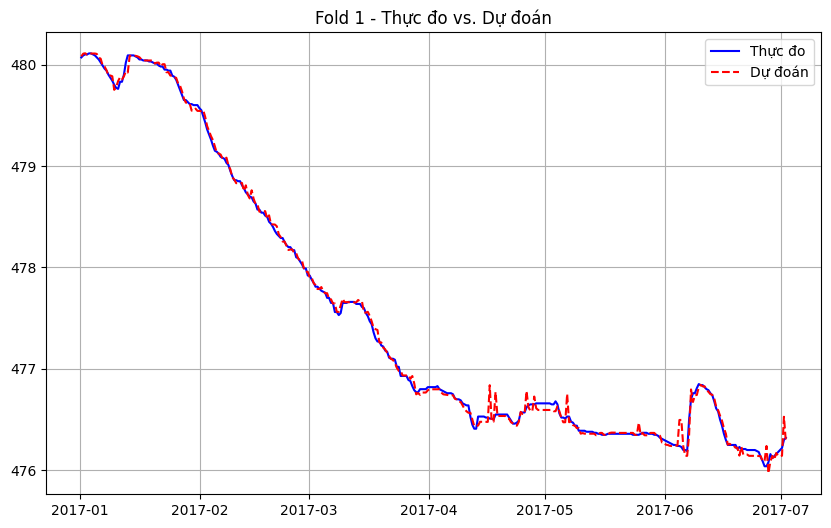

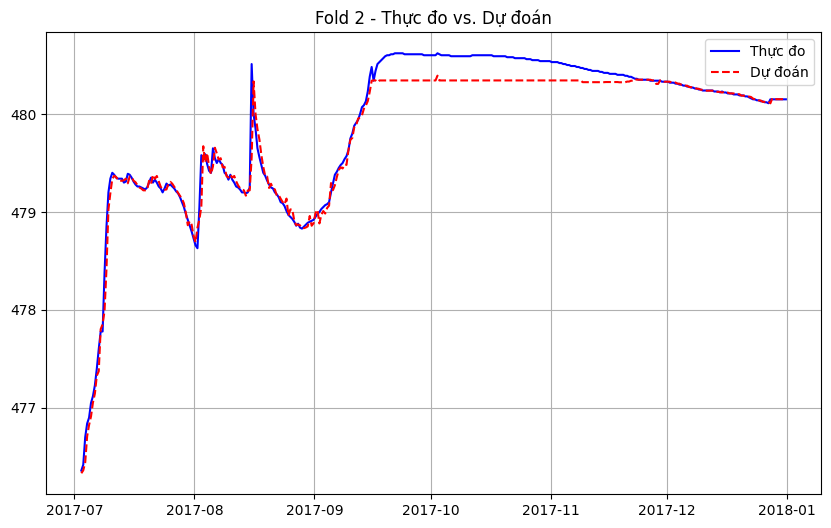

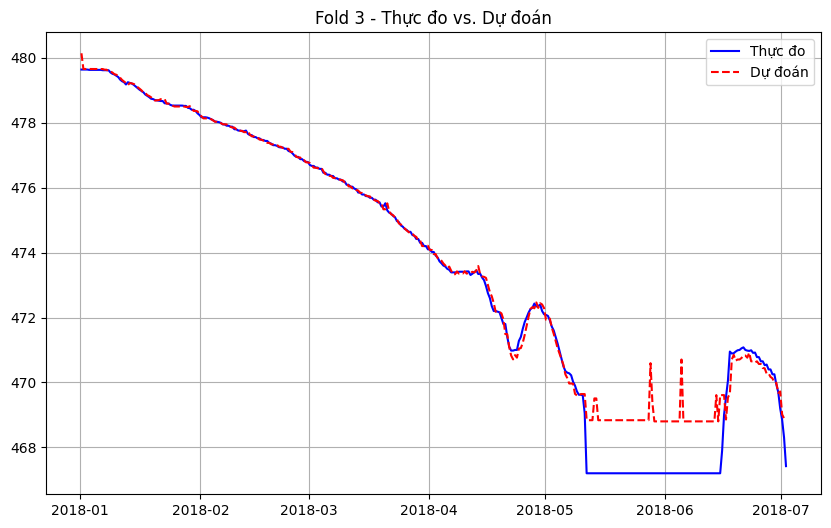

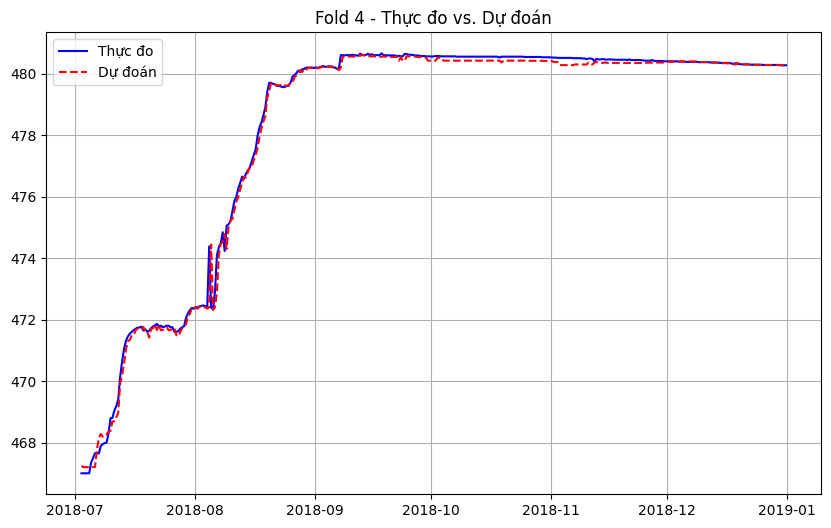

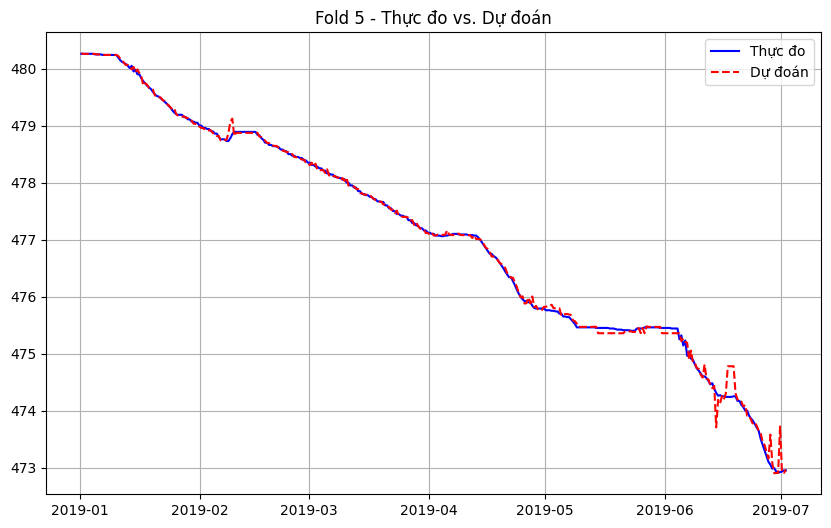

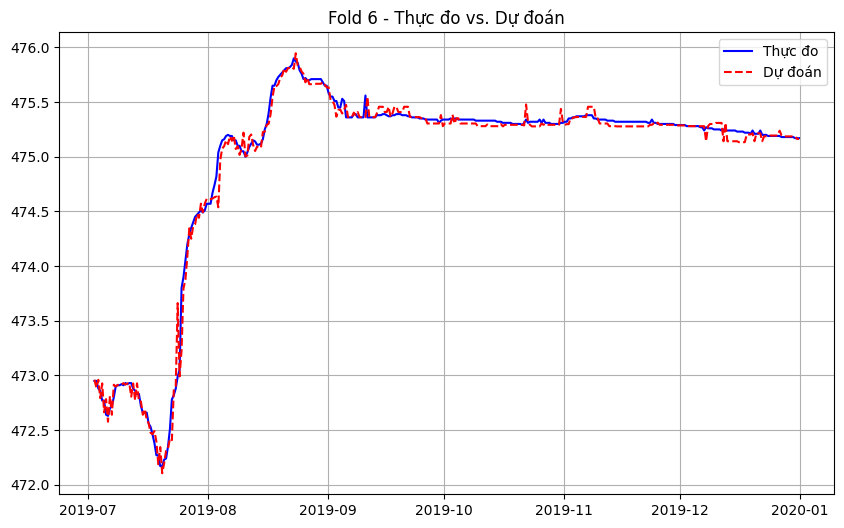

In [17]:
fold = 0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    plt.figure(figsize=(10, 6))
    plt.plot(test.index, test['water_level'], label='Thực đo', color='blue')
    plt.plot(test.index, preds[fold], label='Dự đoán', color='red', linestyle='dashed')
    fold += 1

    plt.title('Fold {} - Thực đo vs. Dự đoán'.format(fold))

    plt.legend()
    plt.grid()
    plt.show()

In [18]:
# Prepare the input data for prediction

input_data = [[27,0,471.8],[49,0,472.35],[26,0,473.15]]

# Create a dataframe from the input data
input_df = pd.DataFrame(input_data)

# Make predictions
predictions = rf_reg.predict(input_df)

# Print the predictions
print(predictions)

[471.96866111 472.70517778 473.27688889]


C:\Users\ADMIN\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
